# Custom Model Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/03-movie-analysis.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.




[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


nohup eva_server >> eva.log 2>&1 &
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF FastRCNNObjectDetector already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF ArrayCount already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Timestamp already exists, nothing added.\n')
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Crop already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF YoloV5 already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Open already exists, nothing added.\n')
('03-18-2023 23:59:49 WARNING[create_udf_executor:create_udf_executor.py:exec:0039] UDF Similarity already exists, nothing added.\n', '03-18-2023 23:59:49 WARNING[create_


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


### Download custom user-defined function (UDF), model, and video

In [2]:
# Download UDF
!wget -nc https://www.dropbox.com/s/nht5lwjemmclqx3/gender.py?raw=1 -O gender.py

# Download built-in Face Detector
!wget -nc https://raw.githubusercontent.com/georgia-tech-db/eva/master/eva/udfs/face_detector.py

# Download models
!wget -nc https://www.dropbox.com/s/yyp7awyczv7esf4/gender.pth?raw=1 -O gender.pth

# Download videos
!wget -nc https://www.dropbox.com/s/f5rorxf0840ajjd/short.mp4?raw=1 -O short.mp4

zsh:1: no matches found: https://www.dropbox.com/s/nht5lwjemmclqx3/gender.py?raw=1


File ‘face_detector.py’ already there; not retrieving.



zsh:1: no matches found: https://www.dropbox.com/s/yyp7awyczv7esf4/gender.pth?raw=1


zsh:1: no matches found: https://www.dropbox.com/s/f5rorxf0840ajjd/short.mp4?raw=1


### Load video for analysis

In [3]:
cursor.execute("DROP TABLE TIKTOK;")
response = cursor.fetch_all()
print(response)
cursor.execute("LOAD VIDEO 'short.mp4' INTO TIKTOK;")
response = cursor.fetch_all()
print(response)
cursor.execute("""SELECT id FROM TIKTOK WHERE id < 5""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                     0
0  Table Successfully dropped: TIKTOK
@query_time: 0.06941328011453152


@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.08731119520962238
@status: ResponseStatus.SUCCESS
@batch: 
    tiktok.id
0          0
1          1
2          2
3          3
4          4
@query_time: 0.08029605075716972


### Visualize Video

In [4]:
from IPython.display import Video
Video("short.mp4", embed=True)

### Create GenderCNN and FaceDetector UDFs

In [5]:
cursor.execute("""DROP UDF GenderCNN;""")
response = cursor.fetch_all()
print(response)

cursor.execute("""CREATE UDF IF NOT EXISTS 
                  GenderCNN
                  INPUT (data NDARRAY UINT8(3, 224, 224)) 
                  OUTPUT (label TEXT(10)) 
                  TYPE  Classification 
                  IMPL 'gender.py';
        """)
response = cursor.fetch_all()
print(response)

cursor.execute("""CREATE UDF IF NOT EXISTS
                  FaceDetector
                  INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
                  OUTPUT (bboxes NDARRAY FLOAT32(ANYDIM, 4),
                          scores NDARRAY FLOAT32(ANYDIM))
                  TYPE  FaceDetection
                  IMPL  'face_detector.py';
        """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                     0
0  UDF GenderCNN successfully dropped
@query_time: 0.03366667963564396


@status: ResponseStatus.SUCCESS
@batch: 
                                                    0
0  UDF GenderCNN successfully added to the database.
@query_time: 1.9690766520798206
@status: ResponseStatus.SUCCESS
@batch: 
                                                  0
0  UDF FaceDetector already exists, nothing added.
@query_time: 0.01021404005587101


### Run Face Detector on video

In [6]:
cursor.execute("""SELECT id, FaceDetector(data).bboxes 
                  FROM TIKTOK WHERE id < 10""")
response = cursor.fetch_all()
response.as_df()

tiktok.id                             facedetector.bboxes
0          0  [[81.550095, 194.44315, 282.48828, 470.52686]]
1          1     [[82.0474, 194.53293, 283.55875, 469.9689]]
2          2   [[82.82503, 195.41945, 283.66702, 470.90152]]
3          3   [[82.303955, 194.59558, 284.48358, 472.1896]]
4          4   [[84.18652, 197.44724, 283.52615, 472.64938]]
5          5       [[85.4966, 199.495, 283.7078, 471.90387]]
6          6   [[84.68376, 199.25592, 284.20886, 472.54736]]
7          7     [[84.99341, 198.98734, 284.2656, 473.8256]]
8          8     [[85.44687, 197.17926, 283.821, 472.35416]]
9          9    [[86.1794, 198.63774, 282.77466, 476.04675]]

### Composing UDFs in a query

Detect gender of the faces detected in the video by composing a set of UDFs (GenderCNN, FaceDetector, and Crop)

In [7]:
cursor.execute("""SELECT id, bbox, GenderCNN(Crop(data, bbox)) 
                  FROM TIKTOK JOIN LATERAL  UNNEST(FaceDetector(data)) AS Face(bbox, conf)  
                  WHERE id < 50;""")
response = cursor.fetch_all()
response.as_df()

tiktok.id                                     Face.bbox gendercnn.label
0           0  [81.550095, 194.44318, 282.48828, 470.52686]          female
1           1    [82.04739, 194.53293, 283.55875, 469.9689]          female
2           2    [82.82503, 195.41945, 283.66702, 470.9015]          female
3           3   [82.303955, 194.59558, 284.48358, 472.1896]          female
4           4    [84.18652, 197.44724, 283.52615, 472.6494]          female
5           5     [85.496605, 199.495, 283.7078, 471.90387]          female
6           6    [84.68376, 199.25592, 284.20886, 472.5474]          female
7           7     [84.99341, 198.98734, 284.2656, 473.8256]          female
8           8     [85.44687, 197.17924, 283.821, 472.35416]          female
9           9   [86.17939, 198.63776, 282.77466, 476.04675]          female
10         10   [85.25071, 199.63634, 283.16684, 477.70276]          female
11         11   [85.06002, 200.41916, 282.78976, 478.53973]          female
12         12    [94.996445, 199.7619, 288.2182, 481.22412]          female
13         13     [93.78287, 199.56308, 285.6612, 480.3683]          female
14         14    [95.37216, 203.2214, 288.06284, 481.11423]          female
15         15      [95.504944, 201.8905, 287.08, 479.11673]          female
16         16    [95.25021, 205.28629, 287.82123, 476.8087]          female
17         17   [94.554214, 204.66628, 287.4455, 475.89926]          female
18         18   [84.89587, 203.04701, 283.62555, 484.46295]          female
19         19     [86.487, 196.90479, 283.29608, 474.85583]          female
20         20    [84.83051, 198.45613, 280.60126, 476.7469]          female
21         21   [82.43199, 206.14032, 278.84897, 483.20398]          female
22         22    [81.1012, 207.21289, 277.29294, 481.82935]          female
23         23     [80.96759, 206.67627, 277.3786, 482.4959]          female
24         24   [80.93326, 207.43477, 276.67755, 482.07263]          female
25         25    [82.811035, 209.1989, 276.6533, 481.91855]          female
26         26    [83.60423, 200.47223, 278.84805, 477.8268]          female
27         27   [82.48079, 206.24551, 279.09464, 485.71368]          female
28         28   [82.59599, 204.04625, 280.41202, 485.29785]          female
29         29   [86.50763, 202.02449, 279.42776, 476.62903]          female
30         30    [88.35531, 197.53365, 282.1011, 473.74414]          female
31         31     [87.11221, 205.17267, 284.2295, 482.4157]          female
32         32     [89.74341, 207.567, 284.62994, 482.24966]          female
33         33     [94.55832, 202.66232, 288.4069, 475.0502]          female
34         34    [94.00957, 205.83165, 287.72922, 481.3546]          female
35         35   [95.11455, 203.77101, 288.43384, 479.97504]          female
36         36     [96.8015, 203.03453, 290.01285, 480.2213]          female
37         37    [96.15155, 202.04309, 288.97714, 477.4139]          female
38         38   [96.037346, 201.84015, 289.16223, 475.0719]          female
39         39    [96.71112, 203.31699, 290.5157, 478.80988]          female
40         40   [94.53888, 199.65323, 289.61713, 475.07336]          female
41         41  [93.358665, 199.94777, 288.69083, 474.84952]          female
42         42      [92.45616, 197.643, 289.25684, 472.3235]          female
43         43    [95.66879, 199.97609, 291.43887, 471.5316]          female
44         44   [93.65909, 199.76115, 292.68628, 470.11337]          female
45         45      [93.285, 200.20296, 291.3452, 468.85083]          female
46         46   [94.492455, 209.76953, 285.80212, 480.5781]          female
47         47    [90.30333, 207.59256, 285.78162, 482.4264]          female
48         48   [88.131454, 206.12158, 284.68027, 480.7262]          female
49         49   [88.426895, 207.50479, 283.9851, 480.67242]          female

### Visualize Output

In [8]:
import cv2
from matplotlib import pyplot as plt

def annotate_video(detections, input_video_path, output_video_path):
    color=(207, 248, 64)
    thickness=4

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    # Capture frame-by-frame
    ret, frame = vcap.read()  # ret = 1 if the video is captured; frame is the image

    while ret:
        df = detections
        df = df[['Face.bbox', 'gendercnn.label']][df['tiktok.id'] == frame_id]
        
        if df.size:
            for bbox, label in df.values:
                x1, y1, x2, y2 = bbox
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                frame=cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness) # object bbox
                cv2.putText(frame, str(label), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, thickness-1) # object label
            
            video.write(frame)
            # Show every fifth frame
            if frame_id % 5 == 0:
                plt.imshow(frame)
                plt.show()

        if frame_id == 50:
            return

        frame_id+=1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

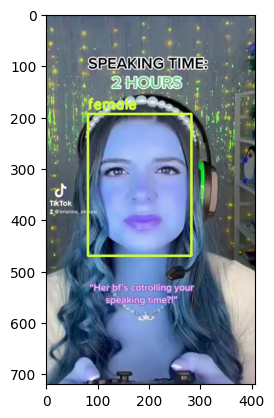

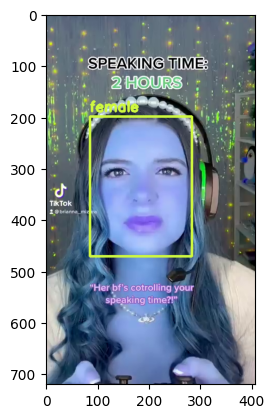

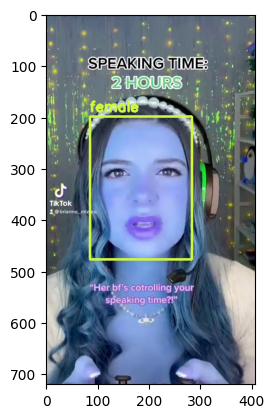

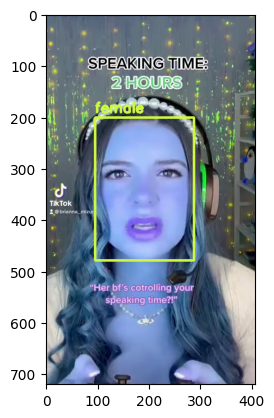

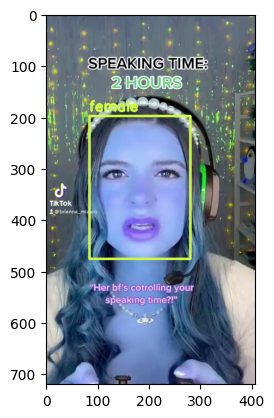

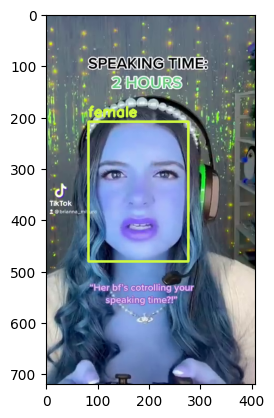

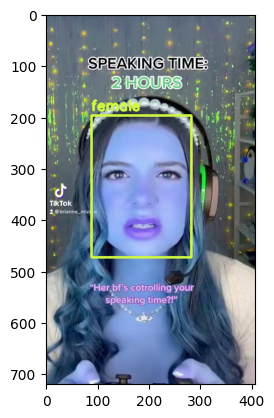

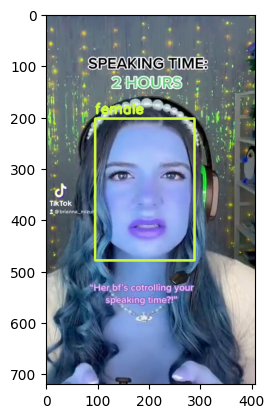

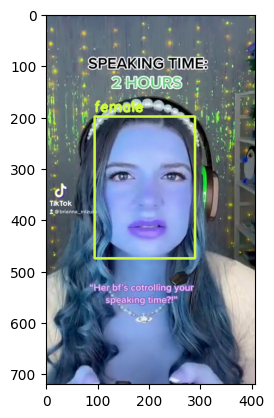

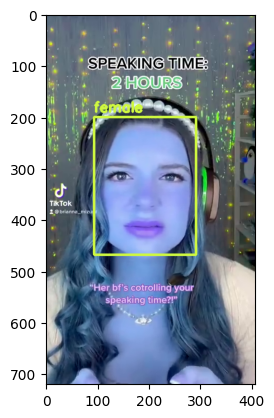

In [9]:
#!pip install ipywidgets
from ipywidgets import Video
input_path = 'short.mp4'
output_path = 'annotated_short.mp4'

dataframe = response.as_df()
annotate_video(dataframe, input_path, output_path)